# **1. Import Library**

In [29]:
# Instalasi library yang dibutuhkan
!pip install google-play-scraper
!pip install gensim

In [30]:
# Import library dasar dan data handling
import os
import re
import csv
import string
import requests
import datetime as dt
from io import StringIO
from functools import lru_cache

# Data handling
import numpy as np
import pandas as pd
from google.colab import files

# Import library scraping data
from google_play_scraper import app, reviews, Sort, reviews_all

# Import library untuk text preprocessing
import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Import library untuk feature engineering
from gensim.models import Word2Vec # Untuk Word2Vec
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Untuk Count/TF-IDF
from sklearn.preprocessing import LabelEncoder # Untuk encoding label

# Import library ML
import joblib
from sklearn.model_selection import train_test_split

# Model Klasifikasi
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

# Evaluasi
from sklearn.metrics import accuracy_score, classification_report

# Import library untuk Deep Learning (TensorFlow/Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model

# Import library visualisasi
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Utilitas
from tqdm import tqdm # Untuk progress bar

In [31]:
pd.options.mode.chained_assignment = None
seed = 0
np.random.seed(seed)
tqdm.pandas()
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

# **2. Scraping Data**

In [32]:
# Ambil review apk Roblox
scrapreview, _ = reviews(
    'com.chess',
    lang='en',
    country='us',
    sort=Sort.MOST_RELEVANT,
    count=150000
)

# Simpan ke CSV
with open('ulasan_aplikasi_chess.csv', mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(['Review'])
    for review in scrapreview:
        writer.writerow([review['content']])

In [33]:
# Lihat informasi teratas csv
df = pd.read_csv('ulasan_aplikasi_chess.csv')
df.head()

,Review
0,The game will force abandon you if you don't p...
1,"Great app but the ""draw"" results are ridiculou..."
2,great app if you like chess. also has some goo...
3,"Easily the premier way to play chess online, a..."
4,This is a very fun game and a well made app. T...


In [34]:
# Menampilkan informasi tentang DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Review  149983 non-null  object
dtypes: object(1)
memory usage: 1.1+ MB


# **3. Cleaning and Pre-Processing Text**

In [35]:
# Cek nilai NaN pada DataFrame
if df.isna().sum().sum() > 0:
    df.dropna(inplace=True)

df.isna().sum()

,0
Review,0


In [36]:
# Cek nilai duplikat pada DataFrame
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)

df.duplicated().sum()

np.int64(0)

In [37]:
# Membersihkan teks dari karakter yang tidak relevan (mention, hashtag, link, angka, dll.)
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r'[0-9]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    text = text.replace('\n', ' ')
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.strip(' ')
    return text

# Mengubah semua karakter dalam teks menjadi huruf kecil
def casefoldingText(text):
    text = text.lower()
    return text

# Memecah string atau teks menjadi daftar token (kata)
def tokenizingText(text):
    text = word_tokenize(text)
    return text

# Menghapus stopwords (kata-kata umum yang tidak penting) dalam teks
listStopwords = set(stopwords.words('indonesian'))
listStopwords_en = set(stopwords.words('english'))
important_words = {
    'no', 'nor', 'not', 'don', "don't", 'ain', 'aren', "aren't",
    'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't",
    'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",
    'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
    'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
    'against', 'very', 'over', 'under'
}
listStopwords_en = listStopwords_en.difference(important_words)
extra_en_stopwords = {
    'lol', 'omg', 'btw', 'brb', 'lmao', 'rofl', 'idk', 'tbh', 'rn', 'smh',
    'pls', 'plz', 'thx', 'ty', 'u', 'ur', 'ya', 'yea', 'ok', 'okay', 'okey',
    'haha', 'hahaha', 'hehe', 'hmm', 'yup', 'nope', 'nah', 'yep', 'cuz',
    'bcuz', 'coz', 'bc', 'tho', 'thru', 'nvm', 'kinda', 'sorta', 'gonna',
    'wanna', 'gotta'
}
listStopwords_en.update(extra_en_stopwords)
listStopwords.update(listStopwords_en)
listStopwords.update([
    'iya','yaa','gak','nya','na','sih','ku','di','ga','ya','gaa','loh','kah','woi','woii','woy'
])
def filteringText(text):
    return [txt for txt in text if txt not in listStopwords]


# Mengurangi kata ke bentuk dasarnya (akar kata)
lemmatizer = WordNetLemmatizer()

# Fungsi bantu: konversi tag POS NLTK ke WordNet
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ, 'N': wordnet.NOUN, 'V': wordnet.VERB, 'R': wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # default = noun

# Fungsi utama Lemmatization
def lemmatizationText(list_words):
    lemmatized_words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in list_words]
    return lemmatized_words

negative_words = {
    "bad": "good", "terrible": "great", "awful": "amazing", "horrible": "wonderful",
    "worst": "best", "poor": "excellent", "sad": "happy", "ugly": "beautiful",
    "hate": "love", "angry": "calm", "slow": "fast", "hard": "easy",
    "broken": "working", "buggy": "stable", "difficult": "simple", "boring": "fun",
    "disappointing": "satisfying", "annoying": "pleasant", "stupid": "smart",
    "worse": "better", "dirty": "clean", "low": "high", "negative": "positive",
    "cheap": "premium", "weak": "strong", "fake": "real", "lazy": "active",
    "fail": "succeed", "messy": "organized", "useless": "useful", "noisy": "quiet",
    "cold": "warm", "tired": "energetic", "uglier": "prettier", "hateful": "kind",
    "incomplete": "complete", "unfair": "fair", "unfriendly": "friendly",
    "unreliable": "reliable", "unhappy": "happy", "unpleasant": "pleasant",
    "uninteresting": "interesting", "unsuccessful": "successful"
}

# Fungsi untuk menangani kata negasi
def handle_negations(tokens):
    new_tokens = []
    skip = False
    for i, word in enumerate(tokens):
        if skip:
            skip = False
            continue

        if word == "not" and i + 1 < len(tokens):
            next_word = tokens[i + 1]

            # Jika kata berikutnya negatif, ubah ke versi positif
            if next_word in negative_words:
                new_tokens.append(negative_words[next_word])
                skip = True
            else:
                new_tokens.append("not")
        else:
            new_tokens.append(word)
    return new_tokens

# Mengubah daftar kata (list) menjadi sebuah kalimat (string)
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [38]:
# Menghapus kumpulan slang words atau kata-kata informal
slangwords = {
    # Bahasa Indonesia
    "@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar",
    "bgt": "banget", "maks": "maksimal", "g": "gue", "gw": "gue", "gua": "saya", "aq": "aku",
    "jg": "juga", "aja": "saja", "tdk": "tidak", "gak": "tidak", "ga": "tidak", "nggak": "tidak",
    "bkn": "bukan", "tuh": "itu", "ni": "ini", "nih": "ini", "skrg": "sekarang", "bbrp": "beberapa",
    "sm": "sama", "dlm": "dalam", "sbg": "sebagai", "dr": "dari", "kyk": "seperti", "kalo": "kalau",
    "kl": "kalau", "klo": "kalau", "jd": "jadi", "cpt": "cepat", "krn": "karena", "coz": "karena",
    "sbk": "sibuk", "spt": "seperti", "trz": "terus", "hbs": "habis", "blm": "belum", "udh": "sudah",
    "sdh": "sudah", "lg": "lagi", "lgi": "lagi", "dmn": "dimana", "kpn": "kapan", "gmn": "bagaimana",
    "brp": "berapa", "cm": "cuma", "bnyk": "banyak", "mksd": "maksud", "tks": "terima kasih",
    "mksh": "terima kasih", "brg": "barang", "org": "orang", "y": "ya", "d": "di", "u": "kamu",
    "trus": "terus", "tp": "tapi", "ttg": "tentang", "mending": "lebih baik", "kek": "seperti",
    "bgs": "bagus", "gpp": "tidak apa-apa", "wkwk": "tertawa", "hehe": "tertawa",

    # Bahasa Inggris
    "u": "you", "ur": "your", "r": "are", "btw": "by the way", "brb": "be right back",
    "bbl": "be back later", "lol": "laughing out loud", "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing", "omg": "oh my god", "idk": "i do not know",
    "imo": "in my opinion", "imho": "in my humble opinion", "thx": "thanks", "ty": "thank you",
    "np": "no problem", "pls": "please", "plz": "please", "u2": "you too", "tbh": "to be honest",
    "rn": "right now", "smh": "shaking my head", "afaik": "as far as i know", "fyi": "for your information",
    "asap": "as soon as possible", "b4": "before", "bc": "because", "idc": "i do not care",
    "omw": "on my way", "ikr": "i know right", "nvm": "never mind", "ttyl": "talk to you later",
    "wyd": "what are you doing", "wya": "where are you", "luv": "love", "cya": "see you",
    "bday": "birthday", "gr8": "great", "4u": "for you", "2day": "today", "2moro": "tomorrow",
    "xoxo": "hugs and kisses", "bff": "best friend forever", "ftw": "for the win", "irl": "in real life",
    "gg": "good game", "wtf": "what the fuck", "wth": "what the hell", "tbt": "throwback thursday",
    "jk": "just kidding", "bcuz": "because", "coz": "because", "cuz": "because", "sry": "sorry",
    "ya": "yeah", "yea": "yeah", "nah": "no", "okie": "okay", "okey": "okay", "nite": "night",
    "gonna": "going to", "wanna": "want to", "gotta": "got to", "kinda": "kind of", "sorta": "sort of",
    "lemme": "let me", "gimme": "give me", "ain't": "is not", "can't": "cannot", "don't": "do not",
    "won't": "will not", "yup": "yes", "nope": "no", "tho": "though", "thru": "through"
}


def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        clean_word = re.sub(r'[^\w\s]+$', '', word).lower()

        if clean_word in slangwords:
            fixed_words.append(slangwords[clean_word])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

In [39]:
# Memanggil fungsi pre-processing
print("Memulai Pre-processing Teks:")

# 1. Cleaning Teks
df['text_clean'] = df['Review'].progress_apply(cleaningText)
print("--- Cleaning Text Selesai ---")

# 2. Case Folding Teks
df['text_casefoldingText'] = df['text_clean'].progress_apply(casefoldingText)
print("--- Case Folding Selesai ---")

# 3. Perbaikan Slangword
df['text_slangwords'] = df['text_casefoldingText'].progress_apply(fix_slangwords)
print("--- Perbaikan Slangword Selesai ---")

# 4. Tokenizing Teks
df['text_tokenizingText'] = df['text_slangwords'].progress_apply(tokenizingText)
print("--- Tokenizing Selesai ---")

# 5. Filtering Teks
df['text_stopword'] = df['text_tokenizingText'].progress_apply(filteringText)
print("--- Filtering Selesai ---")

# 6. Lemmetization Teks
df['text_lemmetizationText'] = df['text_stopword'].progress_apply(lemmatizationText)
print("--- Lemmetization Teks Selesai ---")

# 7. Negation Handling
df['text_lemmetizationText'] = df['text_lemmetizationText'].progress_apply(handle_negations)
print("--- Negation Handling Selesai ---")

# 8. Ubah jadi sentence
df['text_akhir'] = df['text_lemmetizationText'].progress_apply(toSentence)
print("--- Stemming Teks Selesai ---")

# 9. Simpan hasil akhir ke CSV
output_path = "hasil_preprocessing.csv"
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"Semua pre-processing selesai!\nFile hasil disimpan ke: {output_path}")

# Download file csv
files.download(output_path)

Memulai Pre-processing Teks:


100%|██████████| 107239/107239 [00:03<00:00, 33692.30it/s]


--- Cleaning Text Selesai ---


100%|██████████| 107239/107239 [00:00<00:00, 291553.67it/s]


--- Case Folding Selesai ---


100%|██████████| 107239/107239 [00:04<00:00, 22761.58it/s]


--- Perbaikan Slangword Selesai ---


100%|██████████| 107239/107239 [00:15<00:00, 6833.96it/s] 


--- Tokenizing Selesai ---


100%|██████████| 107239/107239 [00:00<00:00, 440067.04it/s]


--- Filtering Selesai ---


100%|██████████| 107239/107239 [00:56<00:00, 1897.58it/s]


--- Lemmetization Teks Selesai ---


100%|██████████| 107239/107239 [00:00<00:00, 586569.93it/s]


--- Negation Handling Selesai ---


100%|██████████| 107239/107239 [00:00<00:00, 641611.80it/s]


--- Stemming Teks Selesai ---
Semua pre-processing selesai!
File hasil disimpan ke: hasil_preprocessing.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **4. Labelling**

In [40]:
# Fungsi umum untuk memuat lexicon
def load_lexicon(url, lexicon_name):
    lexicon = dict()
    response = requests.get(url)

    if response.status_code == 200:
        reader = csv.reader(StringIO(response.text), delimiter=',')
        for row in reader:
            if row:  # pastikan baris tidak kosong
                word = row[0].strip().lower()
                score = float(row[1]) if row[1].replace('.', '', 1).isdigit() else 0
                lexicon[word] = score
        print(f"✅ Success: {lexicon_name} loaded with {len(lexicon)} words.")
    else:
        print(f"❌ Failed to fetch {lexicon_name} from URL: {url}")

    return lexicon

def load_bing_lexicon(url, sentiment):
    lexicon = {}
    response = requests.get(url)
    if response.status_code == 200:
        for line in response.text.strip().split('\n'):
            if line and not line.startswith(';'):  # skip comment lines
                lexicon[line.strip().lower()] = 1 if sentiment == "positive" else -1
        print(f"✅ Success: Bing Liu {sentiment} lexicon loaded with {len(lexicon)} words.")
    else:
        print(f"❌ Failed to fetch Bing Liu {sentiment} lexicon.")
    return lexicon

# Bing Liu Lexicon (positif & negatif)
bing_positive_url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/positive-words.txt"
bing_negative_url = "https://raw.githubusercontent.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/master/data/opinion-lexicon-English/negative-words.txt"

lexicon_positive = load_bing_lexicon(bing_positive_url, "positive")
lexicon_negative = load_bing_lexicon(bing_negative_url, "negative")


✅ Success: Bing Liu positive lexicon loaded with 2006 words.
✅ Success: Bing Liu negative lexicon loaded with 4783 words.


In [41]:
# Menghitung skor sentimen dari teks berdasarkan kamus lexicon positif dan negatif, serta menentukan polaritasnya.
def sentiment_analysis_lexicon(text, lexicon_positive, lexicon_negative):
    """
    Menghitung skor sentimen berdasarkan lexicon positif & negatif (Indonesia atau Inggris).
    text : list token kata (sudah di-preprocess)
    lexicon_positive : dict berisi kata positif
    lexicon_negative : dict berisi kata negatif
    """
    score = 0

    for word in text:
        w = word.lower().strip()
        if w in lexicon_positive:
            score += lexicon_positive[w]
        elif w in lexicon_negative:
            score += lexicon_negative[w]

    if score > 0:
        polarity = 'positive'
    elif score < 0:
        polarity = 'negative'
    else:
        polarity = 'neutral'

    return score, polarity

In [42]:
# Sentimen analisis setelah labeling lexicon
results = df['text_lemmetizationText'].apply(
    lambda tokens: sentiment_analysis_lexicon(tokens, lexicon_positive, lexicon_negative)
)

df[['score', 'polarity']] = pd.DataFrame(results.tolist(), index=df.index)
print(df[['text_akhir', 'score', 'polarity']].head(10))

                                          text_akhir  score  polarity
0  game force abandon dont play fast enough like ...      2  positive
1  great app draw result ridiculous people often ...     -3  negative
2  great app like chess also good resource beginn...      5  positive
3  easily premier way play chess online mobile ve...      4  positive
4  very fun game well make app disappoint thing p...      0   neutral
5  great game annoy always begs pay premium subsc...      1  positive
6  chess work intend easy find match however ive ...      1  positive
7  new version go overboard ad unnecessary kill e...     -1  negative
8  chess even little try never get chess much rec...      1  positive
9  cant see move classification postgame analysis...      3  positive


Jumlah masing-masing polaritas:
polarity
positive    64705
neutral     26090
negative    16444
Name: count, dtype: int64


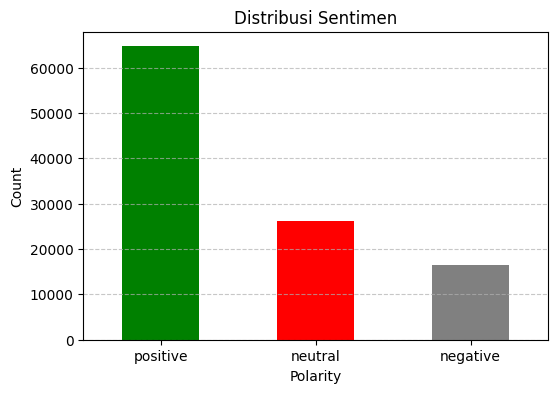

In [43]:
sentiment_counts = df['polarity'].value_counts()
print("Jumlah masing-masing polaritas:")
print(sentiment_counts)

plt.figure(figsize=(6,4))
sentiment_counts.plot(kind='bar', color=['green','red','gray'])
plt.title('Distribusi Sentimen')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

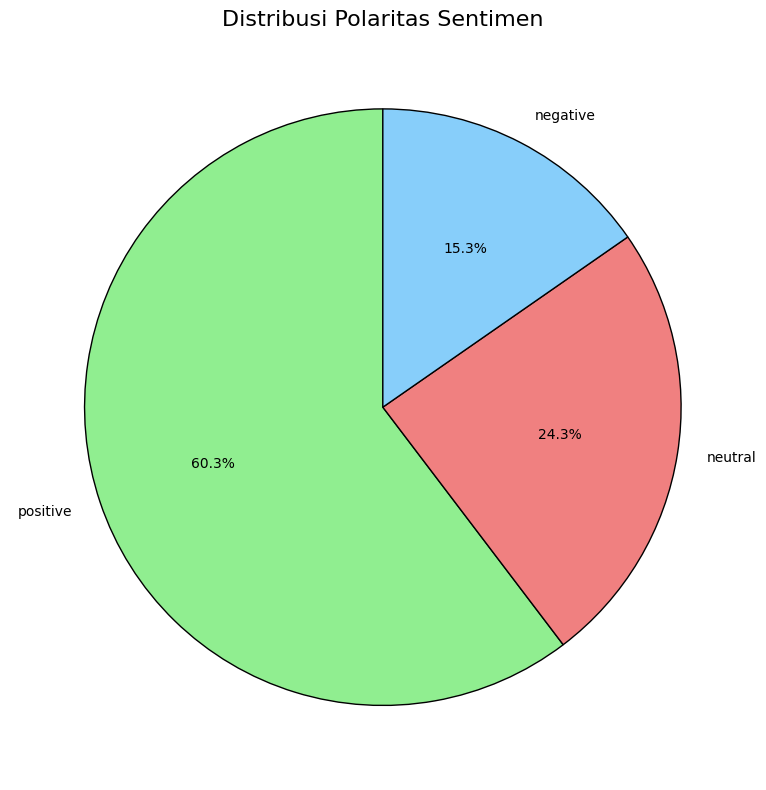

In [44]:
# Hitung frekuensi tiap kategori polaritas
polarity_counts = df['polarity'].value_counts()

# Pie Chart konfigurasi
plt.figure(figsize=(8, 8))
plt.pie(
    polarity_counts.values,            # ambil nilai
    labels=polarity_counts.index,      # label sesuai kategori
    autopct='%1.1f%%',                 # format persentase
    startangle=90,
    colors=['lightgreen', 'lightcoral', 'lightskyblue'][:len(polarity_counts)],  # handle kalau kategori < 3
    wedgeprops={'edgecolor': 'black'}
)

plt.title('Distribusi Polaritas Sentimen', fontsize=16)
plt.tight_layout()
plt.show()


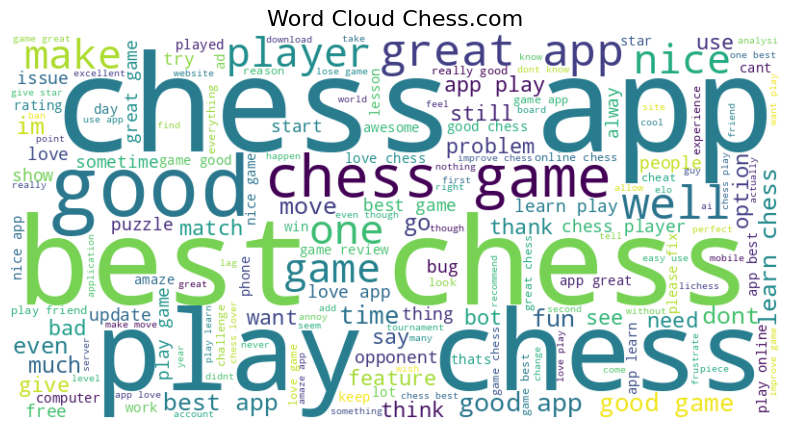

In [45]:
# Word Cloud: gabungan semua kata dari kolom text_stemmingText (yang berisi list of words)
all_words = ' '.join([' '.join(text) for text in df['text_lemmetizationText']])

# Inisialisasi dan Generate WordCloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    min_font_size=10
).generate(all_words)

# Tampilkan WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud Chess.com', fontsize=16)
plt.show()

# **5. Feature Extraction**

In [46]:
# Setup Dataset
X_text = df['text_lemmetizationText']
y = df['polarity']
X_text = df['text_lemmetizationText'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

# Word2Vec Feature Extraction
def word2vec_features(texts, vector_size=100, window=5, min_count=2):
    tokenized = [t.split() if isinstance(t, str) else t for t in texts]

    model = Word2Vec(sentences=tokenized, vector_size=vector_size,
                     window=window, min_count=min_count, workers=4, sg=1)

    embeddings = []
    for tokens in tokenized:
        vectors = [model.wv[w] for w in tokens if w in model.wv]
        if len(vectors) > 0:
            mean_vec = np.mean(vectors, axis=0)
            # Normalisasi biar stabil
            norm = np.linalg.norm(mean_vec)
            embeddings.append(mean_vec / norm if norm != 0 else mean_vec)
        else:
            embeddings.append(np.zeros(vector_size))
    return np.array(embeddings)


# Fungsi Ekstraksi Fitur
def extract_features(method, texts, return_vectorizer=False):
    vec = None  # default

    if method == 'tfidf':
        vec = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.8)
        X = vec.fit_transform(texts)
    elif method == 'bow':
        vec = CountVectorizer(max_features=200, min_df=17, max_df=0.8)
        X = vec.fit_transform(texts)
    elif method == 'ngram':
        vec = CountVectorizer(ngram_range=(1, 2), max_features=200, min_df=17, max_df=0.8)
        X = vec.fit_transform(texts)
    elif method == 'word2vec':
        X = word2vec_features(texts)
    else:
        raise ValueError("❌ Metode tidak dikenal.")

    # Kalau model minta vectorizer-nya juga (buat inference nanti)
    if return_vectorizer and vec is not None:
        return X, vec
    else:
        return X

In [47]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Fungsi evaluasi model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    # Prediksi training dan testing
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Hitung akurasi
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    # Laporan klasifikasi (pakai label asli biar mudah dibaca)
    report = classification_report(
        le.inverse_transform(y_test),
        le.inverse_transform(y_test_pred),
        zero_division=0
    )

    return train_acc, test_acc, report

# === Daftar model ===
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "SVM": LinearSVC(random_state=42),
    "XG Boost": XGBClassifier(eval_metric='logloss')
}

In [48]:
splits = [0.1, 0.2]  # 90:10 dan 80:20
methods = ['tfidf', 'word2vec']
results = []

for method in methods:
    print(f"\n==============================")
    print(f"🔹 Feature: {method.upper()}")
    X_features = extract_features(method, X_text)

    for split in splits:
        X_train, X_test, y_train, y_test = train_test_split(
            X_features, y_encoded, test_size=split, random_state=42
        )
        print(f"  ➤ Split: {int((1 - split) * 100)}:{int(split * 100)}")

        for name, model in models.items():
            # Naive Bayes tidak cocok untuk Word2Vec
            if "word2vec" in method.lower() and "naive" in name.lower():
                print(f"    ⚠️ {name} dilewati (tidak kompatibel dengan Word2Vec).")
                continue
            try:
                train_acc, test_acc, report = evaluate_model(model, X_train, X_test, y_train, y_test)
                results.append({
                    'Feature': method,
                    'Split': f"{int((1 - split) * 100)}:{int(split * 100)}",
                    'Model': name,
                    'Train Accuracy': train_acc,
                    'Test Accuracy': test_acc
                })
                print(f"    {name:<20} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")
            except ValueError as e:
                print(f"    ⚠️ {name} error: {e}")
                continue

# Hasil akhir
results_df = pd.DataFrame(results)
print("\n===== HASIL RINGKAS =====")
display(results_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True))


🔹 Feature: TFIDF
  ➤ Split: 90:10
    Random Forest        | Train: 0.9838 | Test: 0.8726
    Logistic Regression  | Train: 0.9250 | Test: 0.9236
    SVM                  | Train: 0.9137 | Test: 0.9128
    XG Boost             | Train: 0.8960 | Test: 0.8760
  ➤ Split: 80:20
    Random Forest        | Train: 0.9841 | Test: 0.8711
    Logistic Regression  | Train: 0.9241 | Test: 0.9201
    SVM                  | Train: 0.9139 | Test: 0.9106
    XG Boost             | Train: 0.8981 | Test: 0.8710

🔹 Feature: WORD2VEC
  ➤ Split: 90:10
    Random Forest        | Train: 0.9997 | Test: 0.8273
    Logistic Regression  | Train: 0.8283 | Test: 0.8260
    SVM                  | Train: 0.8262 | Test: 0.8231
    XG Boost             | Train: 0.9362 | Test: 0.8543
  ➤ Split: 80:20
    Random Forest        | Train: 0.9997 | Test: 0.8274
    Logistic Regression  | Train: 0.8281 | Test: 0.8242
    SVM                  | Train: 0.8269 | Test: 0.8225
    XG Boost             | Train: 0.9409 | Test: 0.85

,Feature,Split,Model,Train Accuracy,Test Accuracy
0,tfidf,90:10,Logistic Regression,0.925038,0.923629
1,tfidf,80:20,Logistic Regression,0.924095,0.920086
2,tfidf,90:10,SVM,0.913703,0.912812
3,tfidf,80:20,SVM,0.913907,0.910621
4,tfidf,90:10,XG Boost,0.896027,0.875979
5,tfidf,90:10,Random Forest,0.983795,0.872622
6,tfidf,80:20,Random Forest,0.984089,0.871130
7,tfidf,80:20,XG Boost,0.898090,0.870990
8,word2vec,80:20,XG Boost,0.940926,0.855464
9,word2vec,90:10,XG Boost,0.936165,0.854252


# **6. Algoritma Deep Learning**

In [50]:
# Callback untuk stop otomatis berdasarkan train dan test accuracy
class EarlyStopAtDualAccuracy(Callback):
    def __init__(self, threshold=0.93):
        super(EarlyStopAtDualAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get('accuracy')          # Train accuracy
        val_acc = logs.get('val_accuracy')  # Validation (test) accuracy

        if acc is not None and val_acc is not None:
            if acc >= self.threshold and val_acc >= self.threshold:
                print(f"\n✅ Training dihentikan pada epoch {epoch+1}!"
                      f"\n   Train Acc: {acc*100:.2f}% | Val Acc: {val_acc*100:.2f}% "
                      f"(Keduanya sudah ≥ {self.threshold*100:.0f}%)\n")
                self.model.stop_training = True

# Encode label
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Parameter
stop_threshold = 0.93
splits = [0.2]
methods = ['tfidf']
results = []

for method in methods:
    print(f"\n==============================")
    print(f"🔹 Feature: {method.upper()}")

    # Ekstraksi fitur
    X_features, vec = extract_features(method, X_text, return_vectorizer=True)
    joblib.dump(vec, f"{method}_vectorizer.pkl")

    if hasattr(X_features, "toarray"):
        X_features = X_features.toarray().astype('float32')
    else:
        X_features = np.array(X_features, dtype='float32')

    for split in splits:
        print(f"  ➤ Split: {int((1 - split) * 100)}:{int(split * 100)}")

        X_train_text, X_test_text, y_train, y_test = train_test_split(
            X_text, y_encoded, test_size=split, random_state=42
        )

        X_train = vec.transform(X_train_text).toarray().astype('float32')
        X_test = vec.transform(X_test_text).toarray().astype('float32')

        joblib.dump(X_test_text, "test_texts.pkl")
        joblib.dump(y_test, "test_labels.pkl")

        model = Sequential([
            Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(len(np.unique(y_encoded)), activation='softmax')
        ])

        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        early_stop = EarlyStopAtDualAccuracy(threshold=stop_threshold)

        # Training
        history = model.fit(
            X_train, y_train,
            epochs=70,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stop],
            verbose=1
        )

        # Simpan model
        model.save(f"deep_model_{method}.h5")

        # Evaluasi
        train_acc = history.history['accuracy'][-1]
        test_acc = history.history['val_accuracy'][-1]

        results.append({
            'Feature': method,
            'Split': f"{int((1 - split) * 100)}:{int(split * 100)}",
            'Train Accuracy': train_acc,
            'Test Accuracy': test_acc
        })

        print(f"    ✅ Train: {train_acc:.4f} | Test: {test_acc:.4f}")

# Hasil Akhir
results_df = pd.DataFrame(results)
print("\n===== HASIL RINGKAS =====")
display(results_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True))

# Load model & vectorizer
vec = joblib.load("tfidf_vectorizer.pkl")
model = load_model("deep_model_tfidf.h5")


🔹 Feature: TFIDF
  ➤ Split: 80:20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - accuracy: 0.8172 - loss: 0.4563 - val_accuracy: 0.9287 - val_loss: 0.2381
Epoch 2/70
2681/2681 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9262 - loss: 0.2432 - val_accuracy: 0.9299 - val_loss: 0.2331
Epoch 3/70
2669/2681 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9320 - loss: 0.2225
✅ Training dihentikan pada epoch 3!
   Train Acc: 93.04% | Val Acc: 93.09% (Keduanya sudah ≥ 93%)

2681/2681 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9320 - loss: 0.2225 - val_accuracy: 0.9309 - val_loss: 0.2289


    ✅ Train: 0.9304 | Test: 0.9309

===== HASIL RINGKAS =====


,Feature,Split,Train Accuracy,Test Accuracy
0,tfidf,80:20,0.930401,0.930903


# **INFERENCE TESTING**

In [51]:
# Split ulang untuk dapat data test (teks aslinya)
_, X_test_text, _, y_test_text = train_test_split(
    X_text, y_encoded, test_size=0.2, random_state=42
)

# Ambil 20 sample pertama
sample_texts = X_test_text[:20]

# Transform & prediksi
sample_features = vec.transform(sample_texts).toarray().astype('float32')
pred_probs = model.predict(sample_features)
pred_classes = np.argmax(pred_probs, axis=1)
pred_labels = label_encoder.inverse_transform(pred_classes)
pred_conf = np.max(pred_probs, axis=1)

# Buat tabel hasil
results_df = pd.DataFrame({
    "No": range(1, len(sample_texts) + 1),
    "Text": sample_texts,
    "Prediction": pred_labels,
    "Confidence": (pred_conf * 100).round(2).astype(str) + " %"
})

print("\n===== HASIL INFERENCE (20 DATA TEST) =====")
display(results_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

===== HASIL INFERENCE (20 DATA TEST) =====


,No,Text,Prediction,Confidence
140318,1,battery drainage,neutral,91.87 %
107708,2,,neutral,90.11 %
144438,3,one use apps absolutely love,positive,97.54 %
35223,4,excellent learn interaction zone,positive,99.78 %
37354,5,very good app like play chess best place play,positive,100.0 %
138384,6,killer almost good computer exactly need,positive,96.66 %
78289,7,new lay fab time action,neutral,72.41 %
54177,8,very very dope chess app infact best chess app,positive,96.36 %
137806,9,very quick response,neutral,76.46 %
14347,10,internet fine game lag always say low signal c...,negative,99.99 %


# **Requirements**

In [52]:
!pip freeze > requirements.txt
!cat requirements.txt
from google.colab import files
files.download('requirements.txt')

absl-py==1.4.0
absolufy-imports==0.3.1
accelerate==1.10.1
aiofiles==24.1.0
aiohappyeyeballs==2.6.1
aiohttp==3.13.0
aiosignal==1.4.0
alabaster==1.0.0
albucore==0.0.24
albumentations==2.0.8
ale-py==0.11.2
alembic==1.17.0
altair==5.5.0
annotated-types==0.7.0
antlr4-python3-runtime==4.9.3
anyio==4.11.0
anywidget==0.9.18
argon2-cffi==25.1.0
argon2-cffi-bindings==25.1.0
array_record==0.8.1
arrow==1.3.0
arviz==0.22.0
astropy==7.1.1
astropy-iers-data==0.2025.10.13.0.37.17
astunparse==1.6.3
atpublic==5.1
attrs==25.4.0
audioread==3.0.1
Authlib==1.6.5
autograd==1.8.0
babel==2.17.0
backcall==0.2.0
beartype==0.22.2
beautifulsoup4==4.13.5
betterproto==2.0.0b6
bigframes==2.24.0
bigquery-magics==0.10.3
bleach==6.2.0
blinker==1.9.0
blis==1.3.0
blobfile==3.1.0
blosc2==3.10.1
bokeh==3.7.3
Bottleneck==1.4.2
bqplot==0.12.45
branca==0.8.2
Brotli==1.1.0
build==1.3.0
CacheControl==0.14.3
cachetools==5.5.2
catalogue==2.0.10
certifi==2025.10.5
cffi==2.0.0
chardet==5.2.0
charset-normalizer==3.4.4
chex==0.1.90
cl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>